In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.ai.vision.imageanalysis.models import VisualFeatures

from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time
import matplotlib.pyplot as plt
from skimage import io
import numpy as npp

In [2]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

<h3>1</h3>
Sa se foloseasca un algoritm de clasificare a imaginilor (etapa de inferenta/testare) si sa se stabileasca performanta acestui algoritm de clasificare binara (imagini cu biciclete vs. imagini fara biciclete).

In [3]:
predicted_labels=[]


def detect_bike(image_path):
    with open(image_path, "rb") as img:
        result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
        for ob in result.objects:
            if ob.object_property == "bicycle" or ob.object_property == "bike":
                predicted_labels.append(1)
                return True
        predicted_labels.append(0)
        return False

actual_labels=[]

start_time = time.time()
images_folder = "bikes"
for image_name in os.listdir(images_folder):
    if 'bike' in image_name:
        actual_labels.append(1)
    else:
        actual_labels.append(0)
    image_path = os.path.join(images_folder, image_name)
    print(f"{image_name}: {detect_bike(image_path)}")

end_time = time.time()
total_time = end_time - start_time

print(f"Timp: {total_time} secunde")



bike02.jpg: True
bike03.jpg: True
bike04.jpg: True
bike05.jpg: True
bike06.jpg: False
bike07.jpg: True
bike08.jpg: False
bike09.jpg: True
bike1.jpg: True
bike10.jpg: True
traffic01.jpg: False
traffic02.jpg: False
traffic03.jpg: False
traffic04.jpg: False
traffic05.jpg: False
traffic06.jpg: False
traffic07.jpg: False
traffic08.jpg: False
traffic09.jpg: False
traffic10.jpg: False
Timp: 16.33969020843506 secunde


<h3>2 a</h3>
sa se localizeze automat bicicletele in aceste imagini si sa se evidentieze chenarele care incadreaza bicicletele

In [7]:

images_with_bikes = []

for image_name in os.listdir(images_folder):
    image_path = os.path.join(images_folder, image_name)
    with open(image_path, "rb") as img:
        result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
        for ob in result.objects:
            if ob.object_property == "bicycle" or ob.object_property == "bike":
                images_with_bikes.append(image_name)

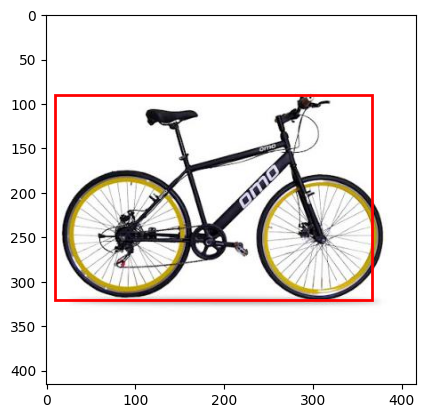

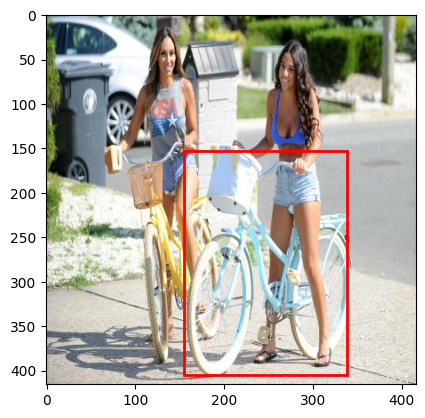

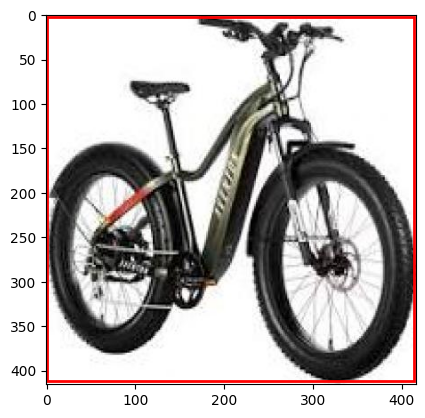

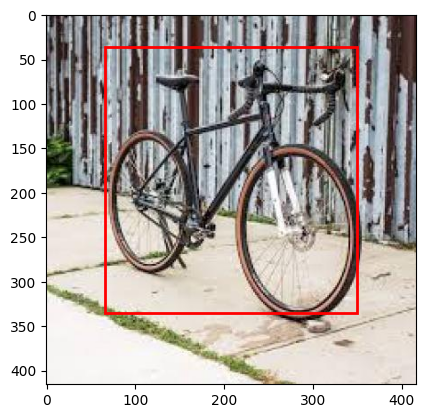

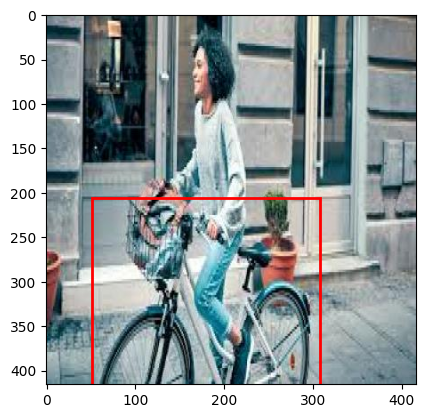

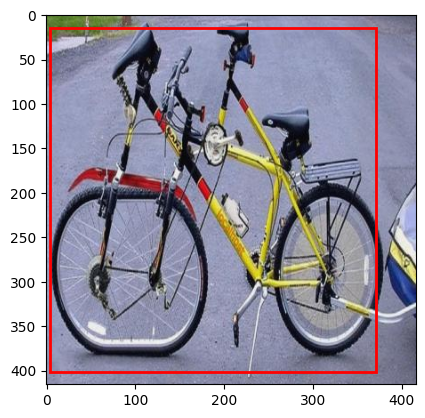

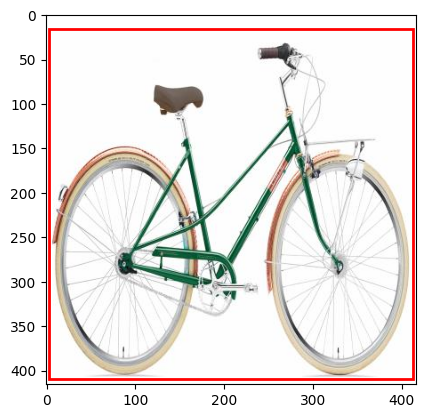

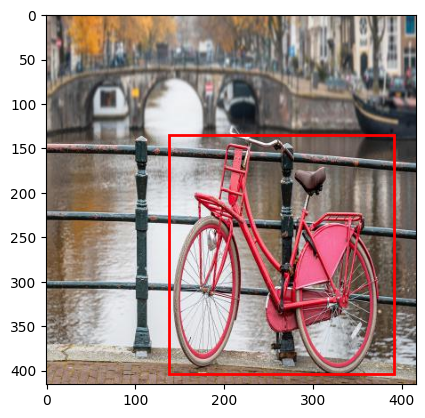

Total time task a: 10.119420766830444 secunde
Predicted bounding boxes:
bike02.jpg: (9, 90, 366, 321)
bike03.jpg: (155, 153, 338, 405)
bike04.jpg: (0, 2, 414, 412)
bike05.jpg: (66, 36, 349, 335)
bike07.jpg: (51, 206, 308, 416)
bike09.jpg: (4, 14, 371, 402)
bike1.jpg: (3, 16, 412, 410)
bike10.jpg: (138, 135, 391, 404)


In [10]:

start_time = time.time()

predicted_bboxes = {}

for image_name in images_with_bikes:
    image_path = os.path.join(images_folder, image_name)
    with open(image_path, "rb") as img:
        result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
        image = plt.imread(image_path)
        plt.imshow(image)
        obj = result.objects[0]
        for ob in result.objects:
             if ob.object_property == "bicycle":
                 obj = ob
                 break
        x, y, w, h = obj.rectangle.x, obj.rectangle.y, obj.rectangle.w, obj.rectangle.h

        predicted_bboxes[image_name] = (x, y, x + w, y + h)

        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))
        plt.show()

end_time = time.time()

total_time_a = end_time - start_time

print(f"Total time task a: {total_time_a} secunde")

print("Predicted bounding boxes:")
for image_name, bbox in predicted_bboxes.items():
    print(f"{image_name}: {bbox}")

<h3> 2 B</h3>
sa se eticheteze (fara ajutorul algoritmilor de AI) aceste imagini cu chenare care sa incadreze cat mai exact bicicletele. Care task dureaza mai mult (cel de la punctul a sau cel de la punctul b)?

In [11]:
import cv2

bounding_boxes = {}

def draw_bounding_boxes(image_path, img_name):
    output_folder = "draw_bikes"
    image = cv2.imread(image_path)
    image_copy = image.copy()
    drawing = False
    ix, iy = -1, -1

    def draw_rectangle(event, x, y, flags, param):
        nonlocal ix, iy, drawing, image_copy

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix, iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                image_copy = image.copy()
                cv2.rectangle(image_copy, (ix, iy), (x, y), (255, 0, 0), 2)
                cv2.imshow("Draw Bounding Box", image_copy)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            fx, fy = x, y

            x_min, y_min = min(ix, fx), min(iy, fy)
            x_max, y_max = max(ix, fx), max(iy, fy)

            bounding_boxes[img_name] = (x_min, y_min, x_max, y_max)

            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.imshow("Draw Bounding Box", image)


    os.makedirs(output_folder, exist_ok=True)

    cv2.namedWindow("Draw Bounding Box")
    cv2.setMouseCallback("Draw Bounding Box", draw_rectangle)

    cv2.imshow("Draw Bounding Box", image)
    cv2.waitKey(0)

    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, image)

    cv2.destroyAllWindows()


def draw():
     for image_name in os.listdir(images_folder):
         if "bike" in image_name:
            image_path = os.path.join(images_folder, image_name)
            draw_bounding_boxes(image_path,image_name)
            print(f"Saved: {image_path}")


In [12]:


start_time = time.time()

draw()

print("Drew bounding boxes:")
for image_name, bbox in bounding_boxes.items():
    print(f"{image_name}: {bbox}")

end_time = time.time()

total_time_b = end_time - start_time

print(f"Total time task b: {total_time_b} secunde")

diferenta_time = total_time_a - total_time_b

print(f"Diferenta time task a si b: {diferenta_time} secunde")


Saved: bikes\bike02.jpg
Saved: bikes\bike03.jpg
Saved: bikes\bike04.jpg
Saved: bikes\bike05.jpg
Saved: bikes\bike06.jpg
Saved: bikes\bike07.jpg
Saved: bikes\bike08.jpg
Saved: bikes\bike09.jpg
Saved: bikes\bike1.jpg
Saved: bikes\bike10.jpg
Drew bounding boxes:
bike02.jpg: (39, 85, 363, 322)
bike03.jpg: (67, 154, 336, 395)
bike04.jpg: (23, 15, 396, 403)
bike05.jpg: (68, 71, 355, 344)
bike06.jpg: (78, 154, 355, 405)
bike07.jpg: (72, 217, 298, 414)
bike08.jpg: (56, 12, 389, 369)
bike09.jpg: (12, 22, 371, 387)
bike1.jpg: (12, 37, 399, 405)
bike10.jpg: (126, 143, 371, 405)
Total time task b: 23.65262484550476 secunde
Diferenta time task a si b: -13.533204078674316 secunde


<h3>2 C</h3>
sa se determine performanta algoritmului de la punctul a avand in vedere etichetarile realizate la punctul b (se vor folosi cel putin 2 metrici).



In [18]:

print("actual labels: ",actual_labels)
print("predicted labels: ",predicted_labels)

TP = sum([1 if (actual_labels[i] == 1 and predicted_labels[i] == 1) else 0 for i in range(len(actual_labels))])
FP = sum([1 if (actual_labels[i] == 0 and predicted_labels[i] == 1) else 0  for i in range(len(actual_labels))])
TN = sum([1 if (actual_labels[i] == 0 and predicted_labels[i] == 0) else 0 for i in range(len(actual_labels))])
FN = sum([1 if (actual_labels[i] == 1 and predicted_labels[i] == 0) else 0  for i in range(len(actual_labels))])

acc = sum([1 if actual_labels[i] == predicted_labels[i] else 0 for i in range(0, len(actual_labels))]) / len(actual_labels)


precisionPos = TP / (TP + FP)
recallPos = TP / (TP + FN)
precisionNeg = TN / (TN + FN)
recallNeg = TN / (TN + FP)

print('acc: ', acc, ' precision: ', precisionPos, ' recall: ', recallPos)


#IoU = Area of Intersection / Area of Union
def IOU(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    intersection = inter_width * inter_height

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union = box1_area + box2_area - intersection

    iou = intersection / union
    return iou


iou_rez = {}

for filename in bounding_boxes:
    if filename in predicted_bboxes:
        iou = IOU(bounding_boxes[filename], predicted_bboxes[filename])
        iou_rez[filename] = iou

for filename, iou in iou_rez.items():
    print(f"{filename}: IoU = {iou:.2f}")




actual labels:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted labels:  [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
acc:  0.9  precision:  1.0  recall:  0.8
acc:  0.9
precision:  1.0
recall:  0.8
bike02.jpg: IoU = 0.89
bike03.jpg: IoU = 0.85
bike04.jpg: IoU = 0.98
bike05.jpg: IoU = 0.89
bike07.jpg: IoU = 0.92
bike09.jpg: IoU = 0.96
bike1.jpg: IoU = 0.93
bike10.jpg: IoU = 0.88
